In [86]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import sentencepiece as spm
import matplotlib.pyplot as plt
import multiprocessing
import time
import math 
from torch.utils.data import Dataset, DataLoader
# device = torch.device('mps')

# Dataset

[0.         0.09429493 0.18858985 ...        nan        nan        nan]


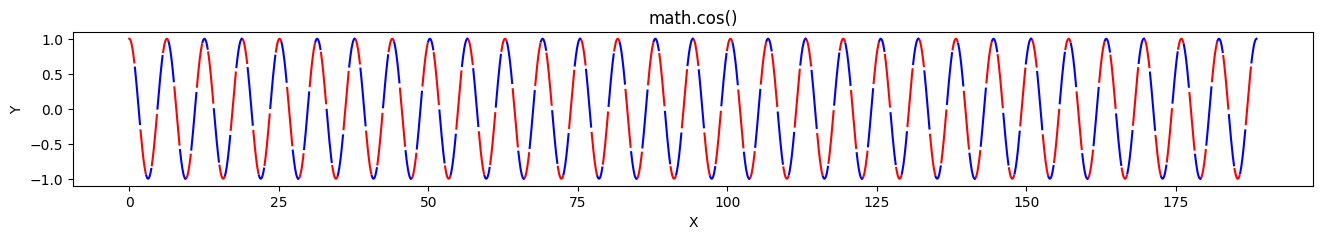

In [87]:
def unknownFunction(x):
    return math.cos(x)

X = np.linspace((0 * np.pi), 60 * np.pi, 2000) 
Y = [] 

for i in range(len(X)): 
    Y.append(unknownFunction(X[i])) 
    i += 1 

Y = np.array(Y)

# Create a mask to keep 10 elements and skip 10 elements repeatedly
# mask = np.tile(np.append(np.ones(10, dtype=bool), np.zeros(10, dtype=bool)), 100)  # 100 repetitions to cover 2000 elements

X_transformed = X.reshape(-1, 10)
Y_transformed = Y.reshape(-1, 10)


X_train = X_transformed[::2]
X_test= X_transformed[1::2]

Y_train = Y_transformed[::2]
Y_test= Y_transformed[1::2]

graph_x_train = np.empty((0,))
for subarray in X_train:
    graph_x_train = np.concatenate((graph_x_train, subarray, np.full(10, np.nan)))

print(graph_x_train)

graph_y_train = np.empty((0,))
for subarray in Y_train:
    graph_y_train = np.concatenate((graph_y_train, subarray, np.full(10, np.nan)))

graph_x_test = np.empty((0,))
for subarray in X_test:
    graph_x_test = np.concatenate((graph_x_test, subarray, np.full(10, np.nan)))

graph_y_test = np.empty((0,))
for subarray in Y_test:
    graph_y_test = np.concatenate((graph_y_test, subarray, np.full(10, np.nan)))


# filtered_array = np.delete(X_train_transformed, np.arange(1, X_train_transformed.shape[0], 2), axis=0)

plt.figure(figsize=(16, 2))
plt.plot(graph_x_train, graph_y_train, color = 'red', marker = "")  
plt.plot(graph_x_test, graph_y_test, color = 'blue', marker = "")  
plt.title("math.cos()")  
plt.xlabel("X")  
plt.ylabel("Y")  
plt.show()  

# Models

In [90]:
class CustomRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomRNNCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.weight_ih = nn.Parameter(torch.randn(input_size, hidden_size))  # Input to hidden weights
        self.weight_hh = nn.Parameter(torch.randn(hidden_size, hidden_size))  # Hidden to hidden weights
        
        self.bias_hh = nn.Parameter(torch.randn(hidden_size))  # Bias

    def forward(self, input, hidden):
        return torch.tanh(
            torch.mm(input, self.weight_ih) + torch.mm(hidden, self.weight_hh) + self.bias_hh
        )
    
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()

        self.hidden_size = hidden_size
        self.rnn_cell = CustomRNNCell(input_size, hidden_size)

        # Adding a linear layer to map from hidden state to a single output value
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        # Assuming input is of shape (batch, seq_len, input_size)
        batch_size, seq_len, _ = input.shape
        hidden = torch.zeros(batch_size, self.hidden_size)  # Initial hidden state
        
        for i in range(seq_len):
            hidden = self.rnn_cell(input[:, i, :] , hidden)

         # Now using the final hidden state to predict the output value
        output = self.fc(hidden)  # Shape: (batch_size, output_size)
        return output

## Run Model

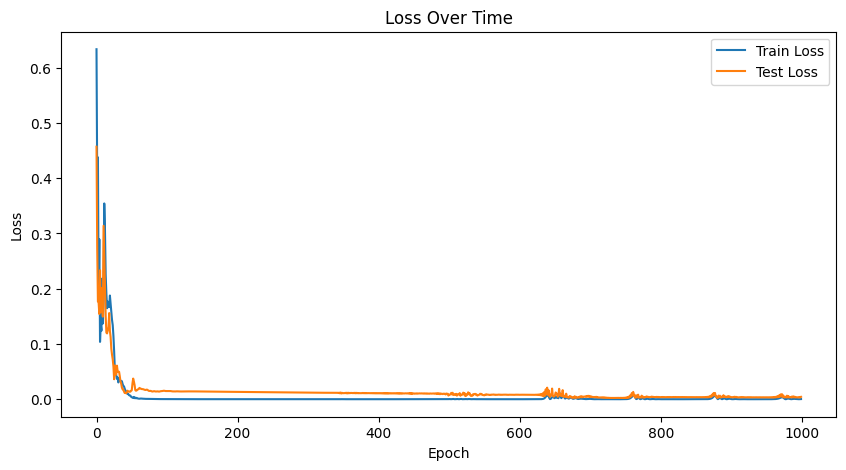

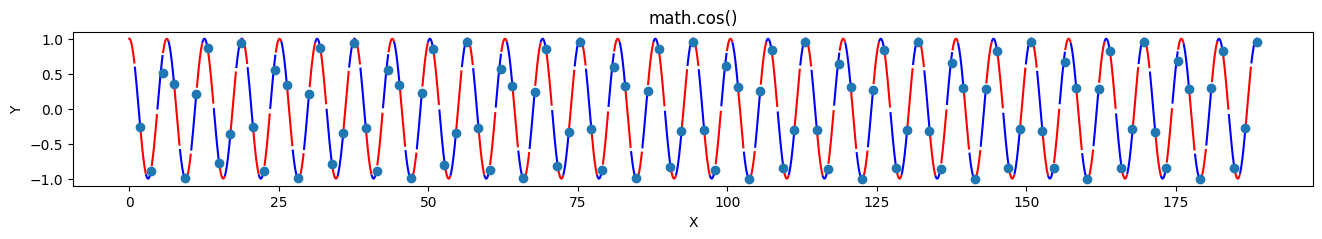

In [155]:
# Initialize the model, loss function, and optimizer
input_size = 1
hidden_size = 20
output_size = 1

model = CustomRNN(input_size, hidden_size, output_size)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.04)

X_train_tensor = torch.from_numpy(X_train.astype(np.float32))
X_train_tensor = X_train_tensor.unsqueeze(-1)

Y_train_tensor = torch.from_numpy(Y_train[:, -1].astype(np.float32))
Y_train_tensor = Y_train_tensor.reshape(-1, 1)
YX_train_tensor =torch.from_numpy(Y_train[:, :9].astype(np.float32)).unsqueeze(-1)

X_test_tensor = torch.from_numpy(X_test.astype(np.float32))
X_test_tensor = X_test_tensor.unsqueeze(-1)

Y_test_tensor = torch.from_numpy(Y_test[:, -1].astype(np.float32))
Y_test_tensor = Y_test_tensor.reshape(-1, 1)
YX_test_tensor =torch.from_numpy(Y_test[:, :9].astype(np.float32)).unsqueeze(-1)

train_losses = []
test_losses = []

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    output = model(YX_train_tensor)
    loss = loss_function(output, Y_train_tensor)
    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    
    model.eval()
    OUT_Y = []
    with torch.no_grad():
        test_outputs = model(YX_test_tensor)
        OUT_X = X_test[:, -1].astype(np.float32)
        
        OUT_Y = test_outputs.squeeze()
        test_loss = loss_function(test_outputs, Y_test_tensor)
    
    # if epoch % 1 == 0:
        # print(f'Epoch {epoch+1}, Train Loss: {loss.item()} Test Loss: {test_loss.item()}')

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

plt.figure(figsize=(16, 2))
plt.plot(graph_x_train, graph_y_train, color = 'red', marker = "")  
plt.plot(graph_x_test, graph_y_test, color = 'blue', marker = "")  
plt.plot(OUT_X, OUT_Y, 'o')
plt.title("math.cos()")  
plt.xlabel("X")  
plt.ylabel("Y")  
plt.show()  